In [26]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime

In [6]:
df = pd.read_csv("data/ivan_data/tsg_gps/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

6859

In [ ]:
len(df)

In [7]:
from datetime import datetime

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

In [8]:
import numpy as np

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

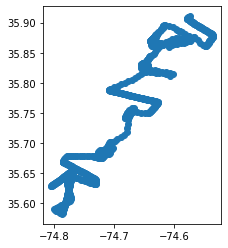

In [9]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [10]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [ ]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

In [209]:
df.loc['2021-08-29 16:15:00':'2021-08-29 17:52:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [36]:
df.loc['2021-08-25 23:00:00':'2021-08-27 17:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.2,tiles='EsriNatGeo', width=500)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [117]:
! ls data/ivan_data/cdom/

cdom_flu_output_210825_1.txt  cdom_flu_output_210828_1.txt
cdom_flu_output_210826_1.txt  cdom_flu_output_210829_1.txt
cdom_flu_output_210827_1.txt


In [118]:
cdom_files = [
    'data/ivan_data/cdom/cdom_flu_output_210825_1.txt',
    'data/ivan_data/cdom/cdom_flu_output_210826_1.txt',
    'data/ivan_data/cdom/cdom_flu_output_210827_1.txt',
    'data/ivan_data/cdom/cdom_flu_output_210828_1.txt',
    'data/ivan_data/cdom/cdom_flu_output_210829_1.txt'
             ]

cdom_dfs = []

for item in cdom_files:
    cdom_data = open(item)
    lines = cdom_data.readlines()
    sensor_values = []
    utc_times = []
    for i in range(len(lines)):
        line = lines[i]
        if "sensor" in line:
            try:
                line = line.split('= ')[1]
                line = line.replace('\n', '')
                sensor_values.append(int(line))
                if "UTC" in lines[i-1]:
                    data_time = lines[i-1][5:-2]
                    utc_times.append(data_time)
                elif "UTC" in lines[i+1]:
                    data_time = lines[i+1][5:-2]
                    utc_times.append(data_time)
            except:
                pass
    print(len(sensor_values)-len(utc_times))
    sensor_values = sensor_values[len(sensor_values)-len(utc_times):]
    utc_times = pd.to_datetime(utc_times)
    cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])
    cdom_df['utc_dt'] = utc_times
    cdom_df  = cdom_df.set_index('utc_dt')
    cdom_dfs.append(cdom_df)
    
cdom_df = pd.DataFrame().append(cdom_dfs)

12
285
2
28
104


#### Visualizing SST from GOES

In [27]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [294]:
goes_ds.sea_surface_temperature[:,:, :].resample(time="6H", skipna=True).mean().hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc['2021-08-27 11:00:00':'2021-08-29 13:45:00'].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

## Working through each transect with data and SST

In [278]:
trios_df.loc[start_times[i]:end_times[i]]

TimeStamp       320       321       322       323  \
utc_dt                                                                         
2021-08-29 16:15:00  8/29/2021 12:15  0.005114  0.005222  0.005263  0.005213   
2021-08-29 16:15:00  8/29/2021 12:15  0.005856  0.005944  0.005960  0.005886   
2021-08-29 16:15:00  8/29/2021 12:15  0.007062  0.007106  0.007089  0.007012   
2021-08-29 16:15:00  8/29/2021 12:15  0.006130  0.006210  0.006234  0.006173   
2021-08-29 16:15:00  8/29/2021 12:15  0.006626  0.006690  0.006703  0.006633   
...                              ...       ...       ...       ...       ...   
2021-08-29 17:52:00  8/29/2021 13:52  0.002777  0.002839  0.002850  0.002798   
2021-08-29 17:52:00  8/29/2021 13:52  0.003774  0.003842  0.003856  0.003789   
2021-08-29 17:52:00  8/29/2021 13:52  0.001452  0.001537  0.001566  0.001542   
2021-08-29 17:52:00  8/29/2021 13:52  0.003012  0.003079  0.003090  0.003043   
2021-08-29 17:52:00  8/29/2021 13:52  0.002853  0.002937  0.002966  0.002927   

                          324       325       326       327       328  ...  \
utc_dt                                                                 ...   
2021-08-29 16:15:00  0.005151  0.005104  0.005136  0.005065  0.004927  ...   
2021-08-29 16:15:00  0.005808  0.005748  0.005771  0.005692  0.005550  ...   
2021-08-29 16:15:00  0.006933  0.006873  0.006898  0.006812  0.006656  ...   
2021-08-29 16:15:00  0.006105  0.006053  0.006076  0.005999  0.005859  ...   
2021-08-29 16:15:00  0.006552  0.006487  0.006513  0.006442  0.006306  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:52:00  0.002736  0.002688  0.002693  0.002619  0.002499  ...   
2021-08-29 17:52:00  0.003713  0.003653  0.003656  0.003576  0.003444  ...   
2021-08-29 17:52:00  0.001499  0.001469  0.001481  0.001419  0.001315  ...   
2021-08-29 17:52:00  0.002984  0.002939  0.002942  0.002853  0.002712  ...   
2021-08-29 17:52:00  0.002870  0.002827  0.002837  0.002764  0.002643  ...   

                          943       944       945       946       947  \
utc_dt                                                                  
2021-08-29 16:15:00 -0.000501 -0.000380 -0.000261 -0.000355 -0.000570   
2021-08-29 16:15:00  0.000016  0.000121  0.000225  0.000099 -0.000029   
2021-08-29 16:15:00  0.000598  0.000537  0.000477  0.000580  0.000604   
2021-08-29 16:15:00  0.000535  0.000505  0.000473  0.000465  0.000465   
2021-08-29 16:15:00  0.000073  0.000190  0.000306  0.000350  0.000381   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:52:00 -0.000041 -0.000035 -0.000029 -0.000041 -0.000061   
2021-08-29 17:52:00  0.000366  0.000342  0.000317  0.000404  0.000502   
2021-08-29 17:52:00  0.001498  0.001444  0.001389  0.001370  0.001338   
2021-08-29 17:52:00 -0.000157 -0.000236 -0.000317 -0.000353 -0.000367   
2021-08-29 17:52:00  0.002718  0.002682  0.002644  0.002705  0.002788   

                          948       949       950            datetime  \
utc_dt                                                                  
2021-08-29 16:15:00 -0.000821 -0.000906 -0.000869 2021-08-29 12:15:00   
2021-08-29 16:15:00 -0.000143 -0.000068  0.000041 2021-08-29 12:15:00   
2021-08-29 16:15:00  0.000588  0.000598  0.000657 2021-08-29 12:15:00   
2021-08-29 16:15:00  0.000468  0.000540  0.000640 2021-08-29 12:15:00   
2021-08-29 16:15:00  0.000411  0.000389  0.000327 2021-08-29 12:15:00   
...                       ...       ...       ...                 ...   
2021-08-29 17:52:00 -0.000083 -0.000048 -0.000013 2021-08-29 13:52:00   
2021-08-29 17:52:00  0.000597  0.000612  0.000566 2021-08-29 13:52:00   
2021-08-29 17:52:00  0.001298  0.001265  0.001236 2021-08-29 13:52:00   
2021-08-29 17:52:00 -0.000375 -0.000349 -0.000317 2021-08-29 13:52:00   
2021-08-29 17:52:00  0.002874  0.002810  0.002693 2021-08-29 13:52:00   

                     chla_oci  
utc_dt                         
2021-08

In [291]:
plt.rcParams.update({'font.size': 14})

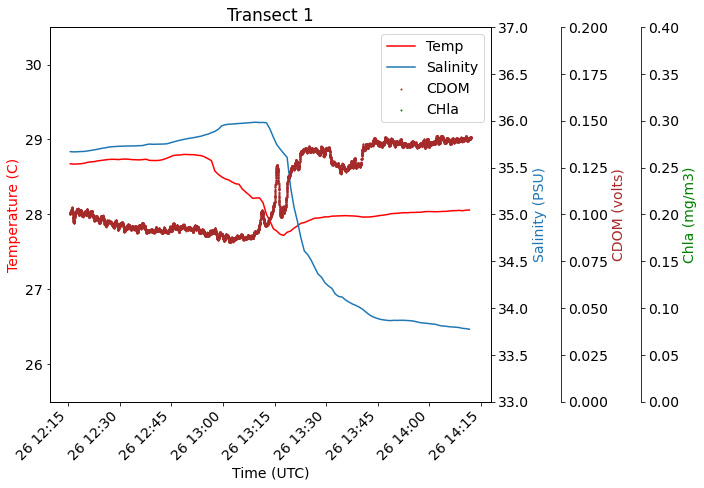

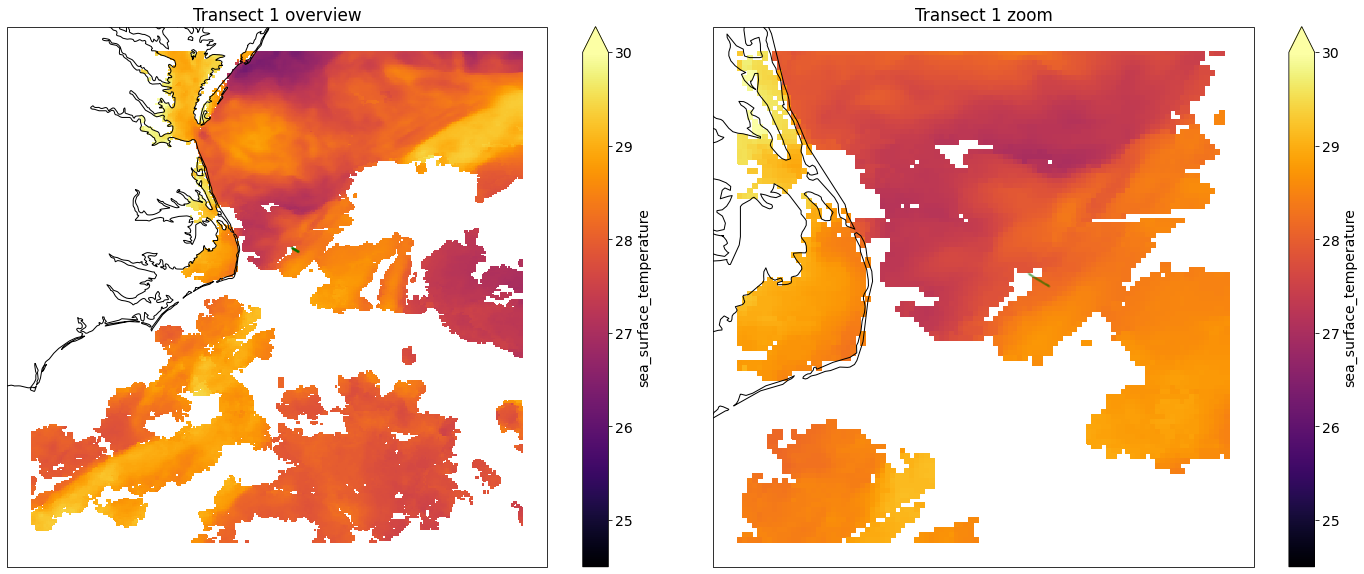

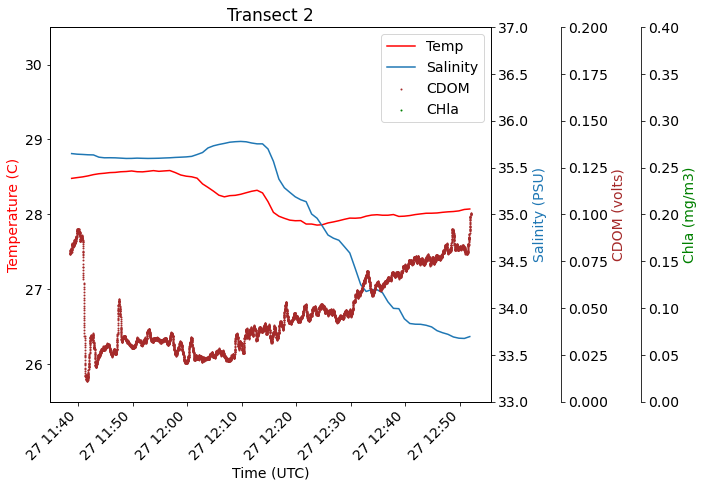

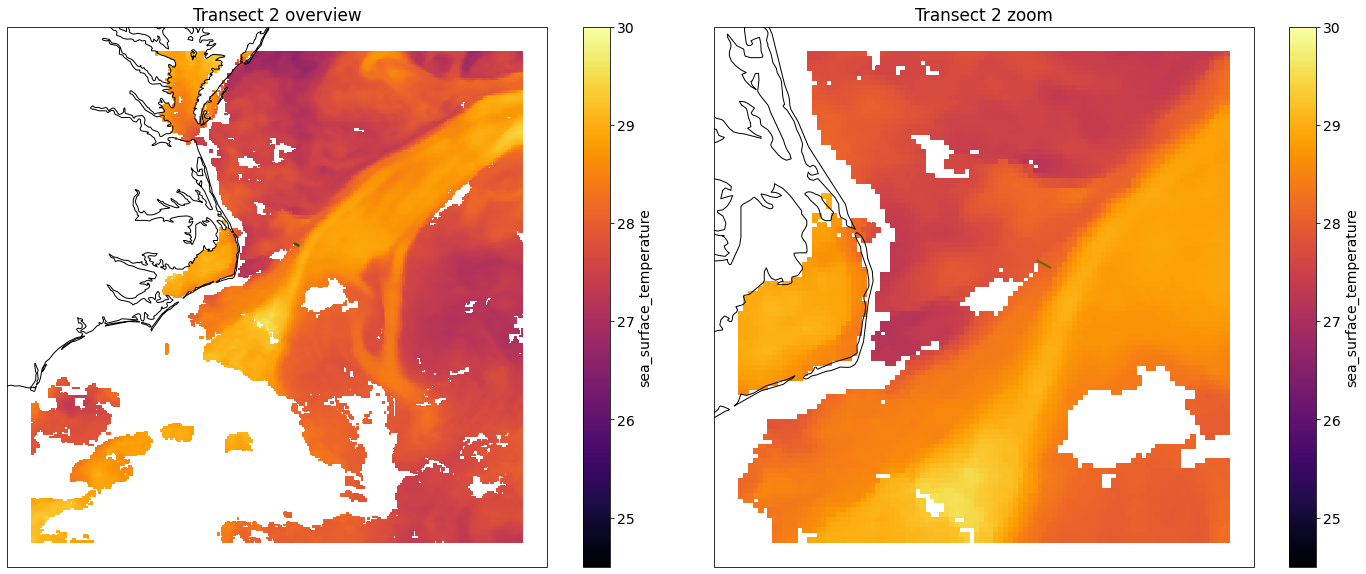

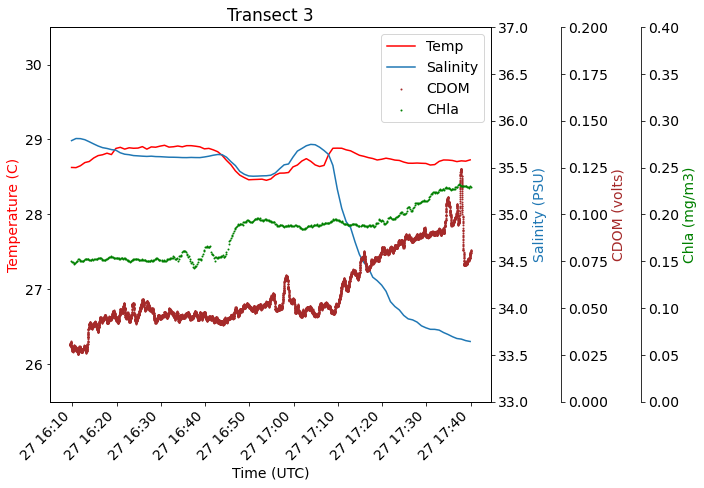

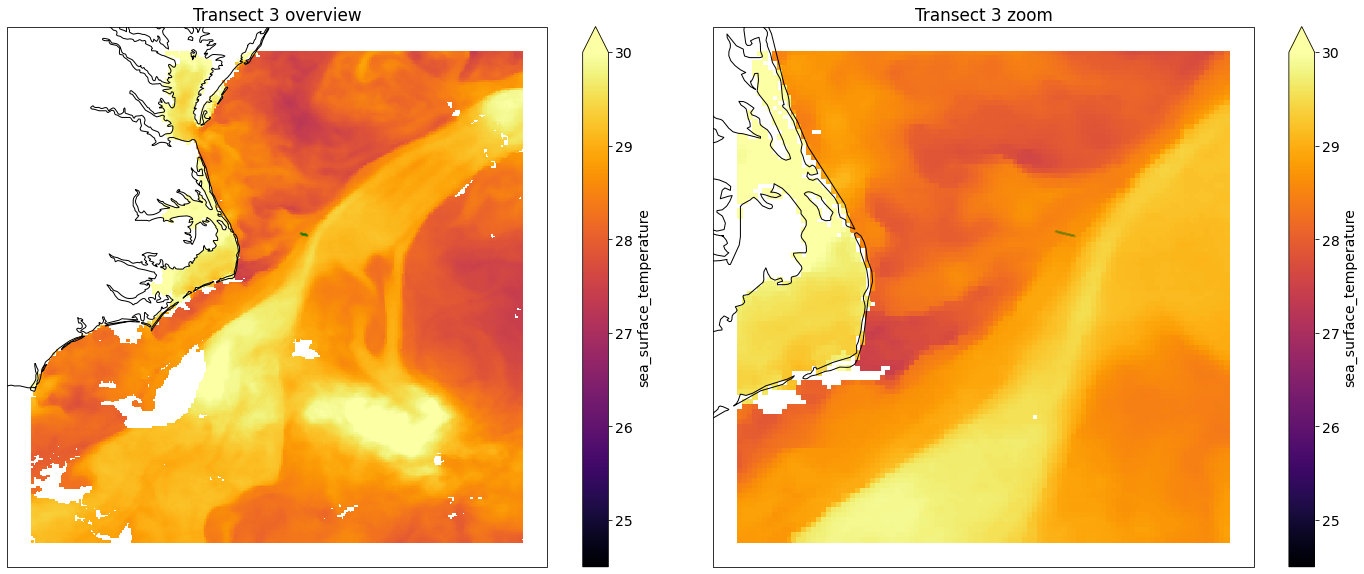

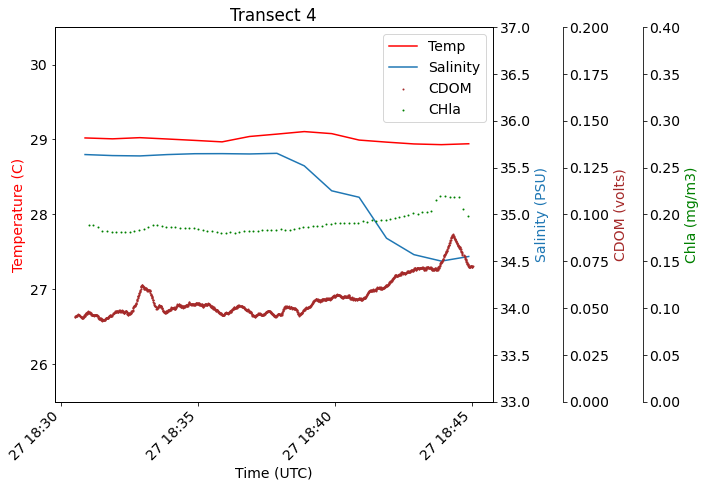

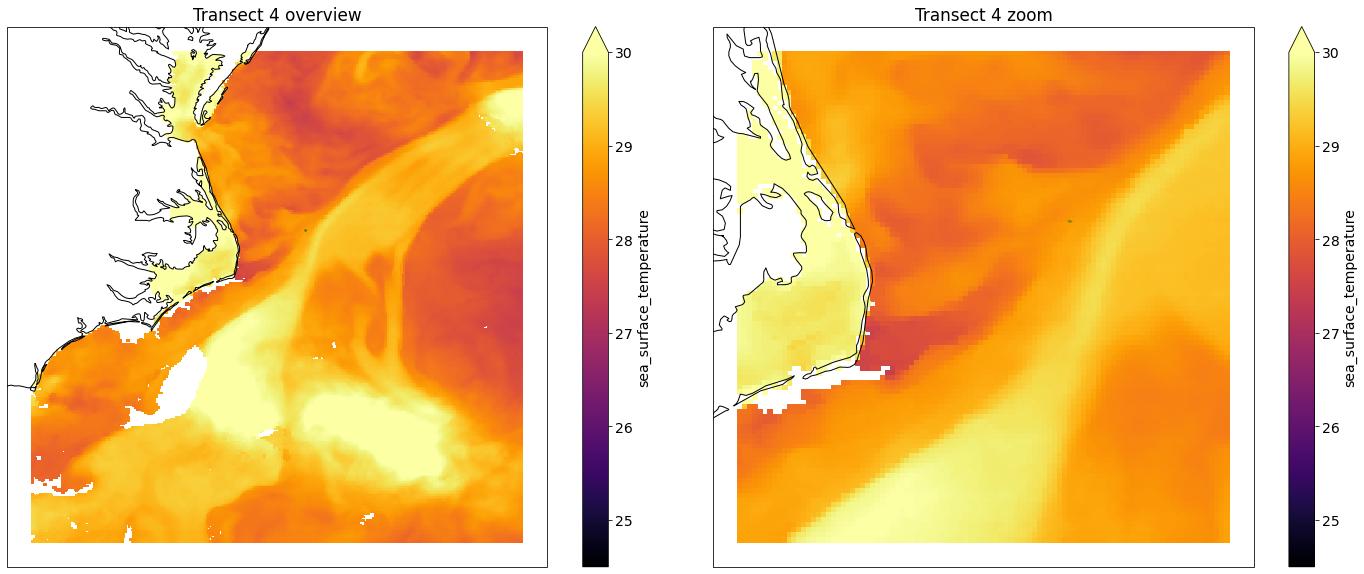

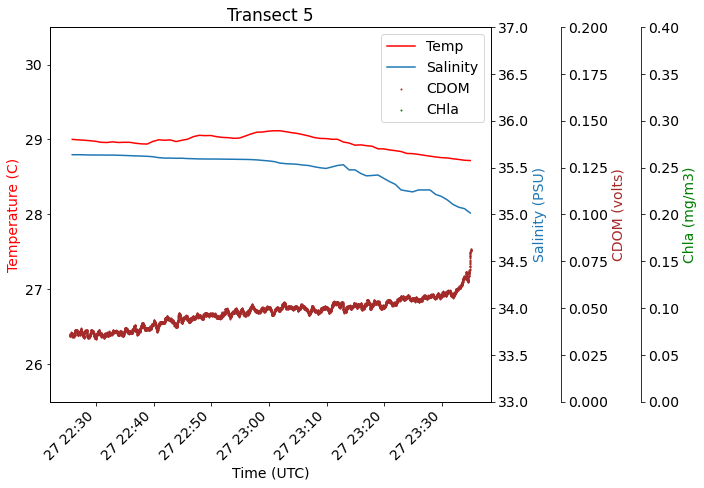

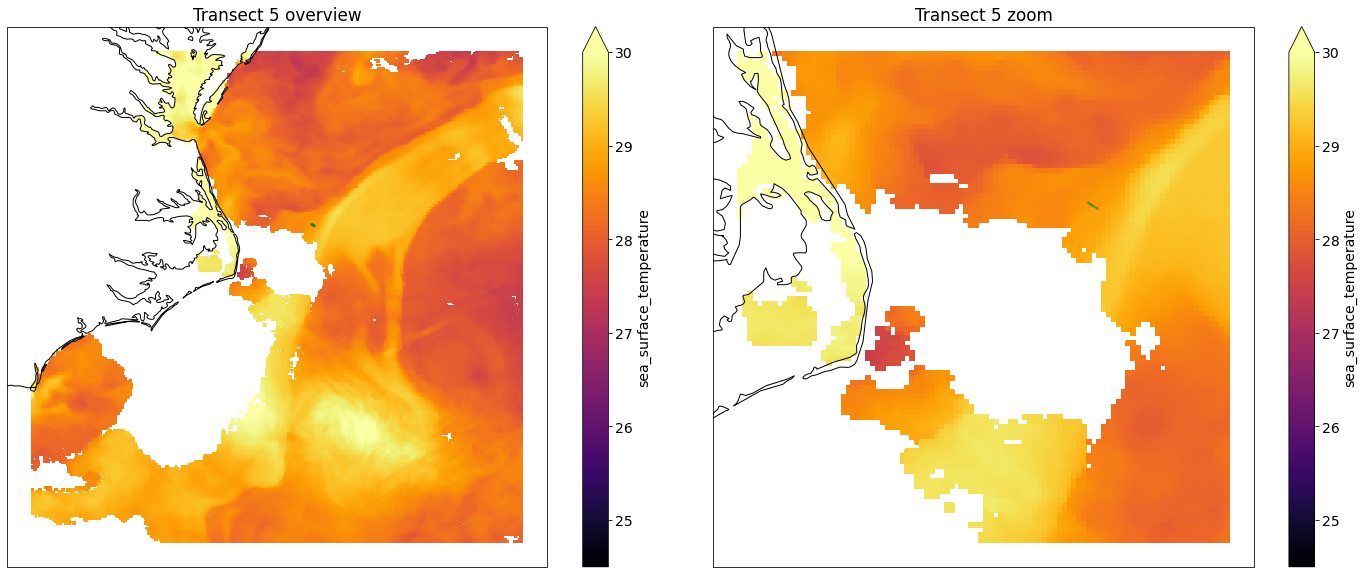

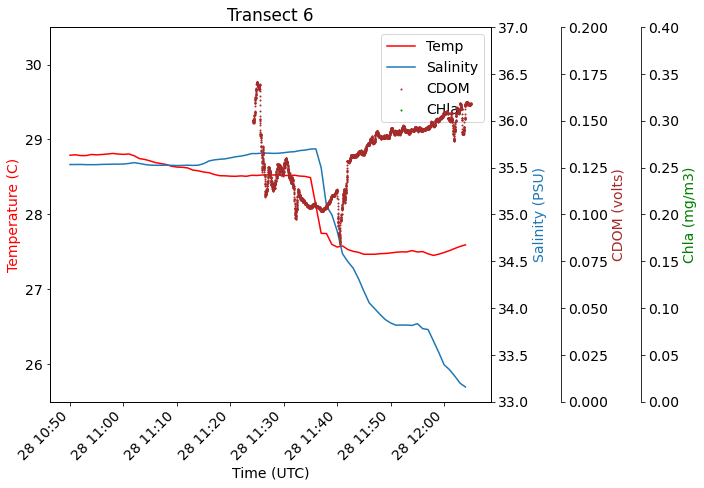

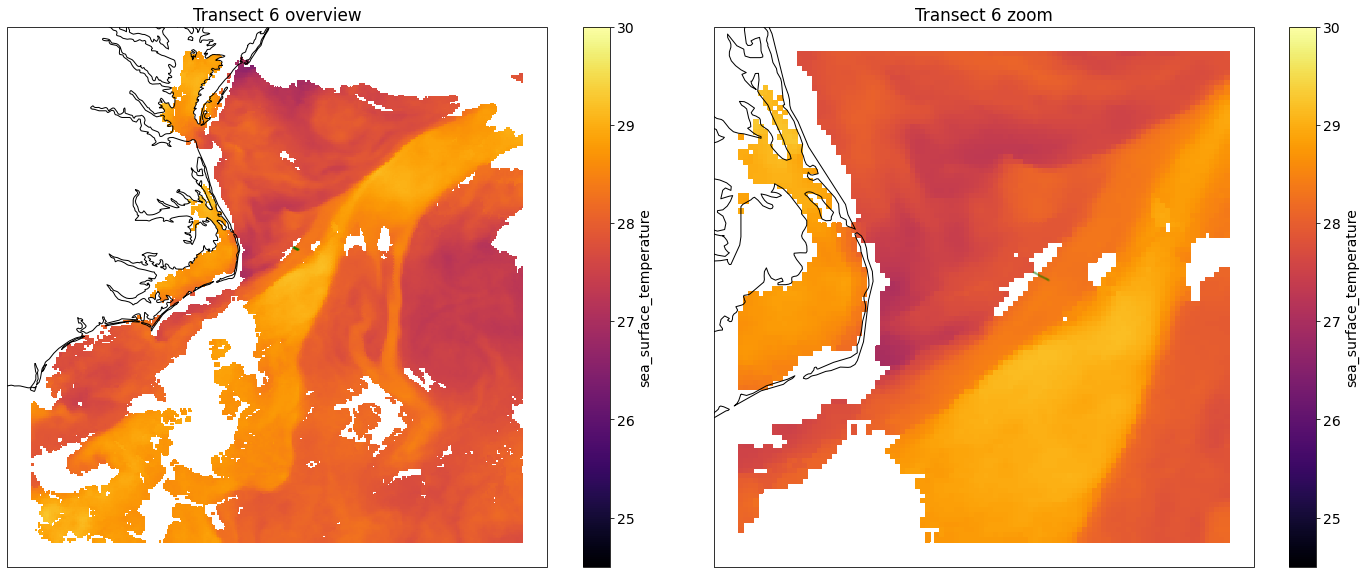

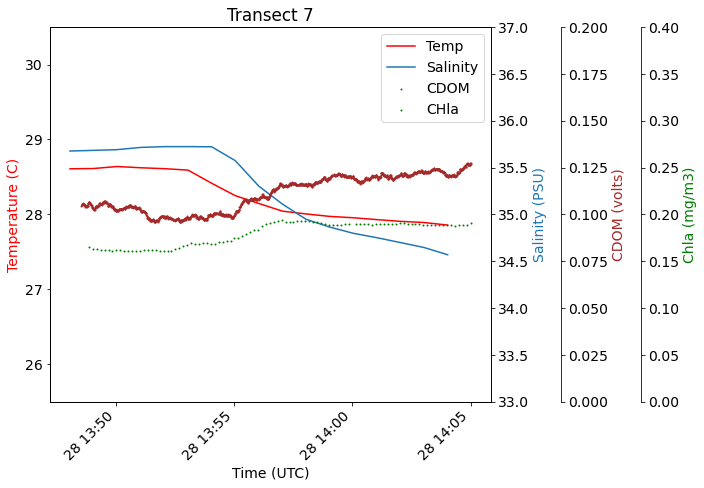

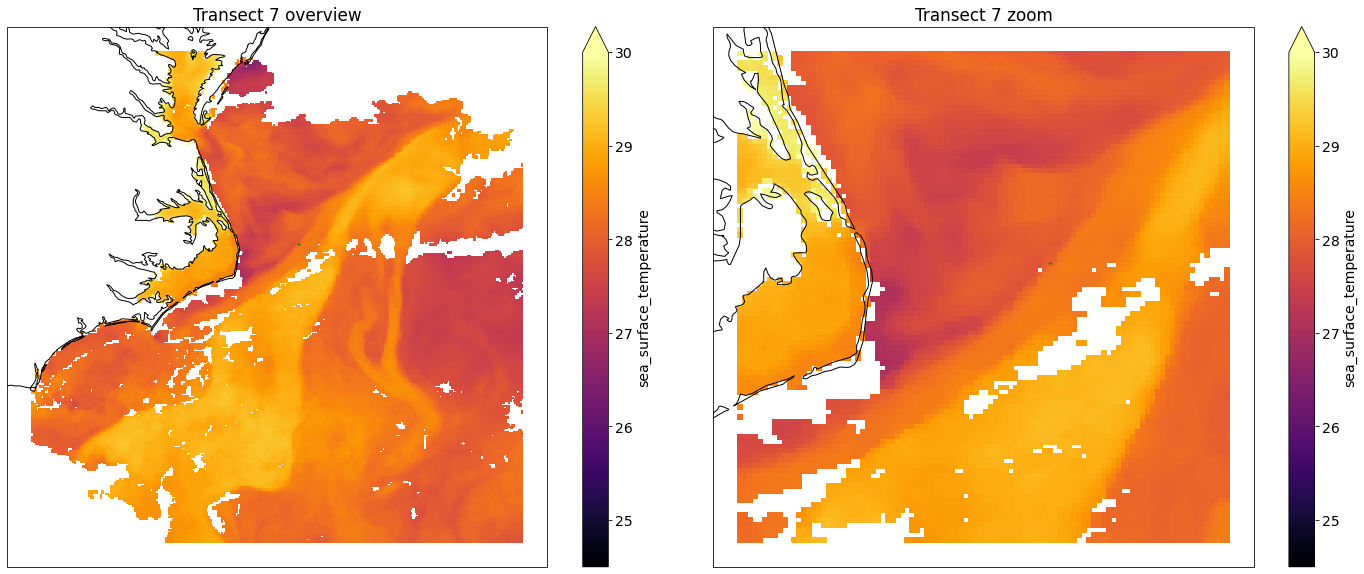

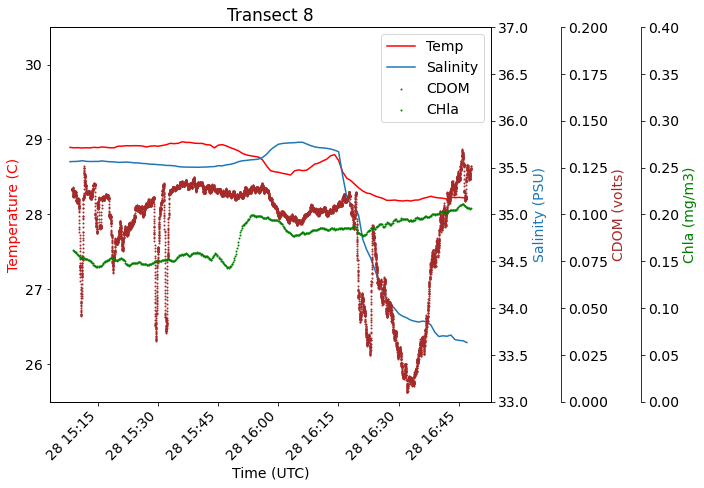

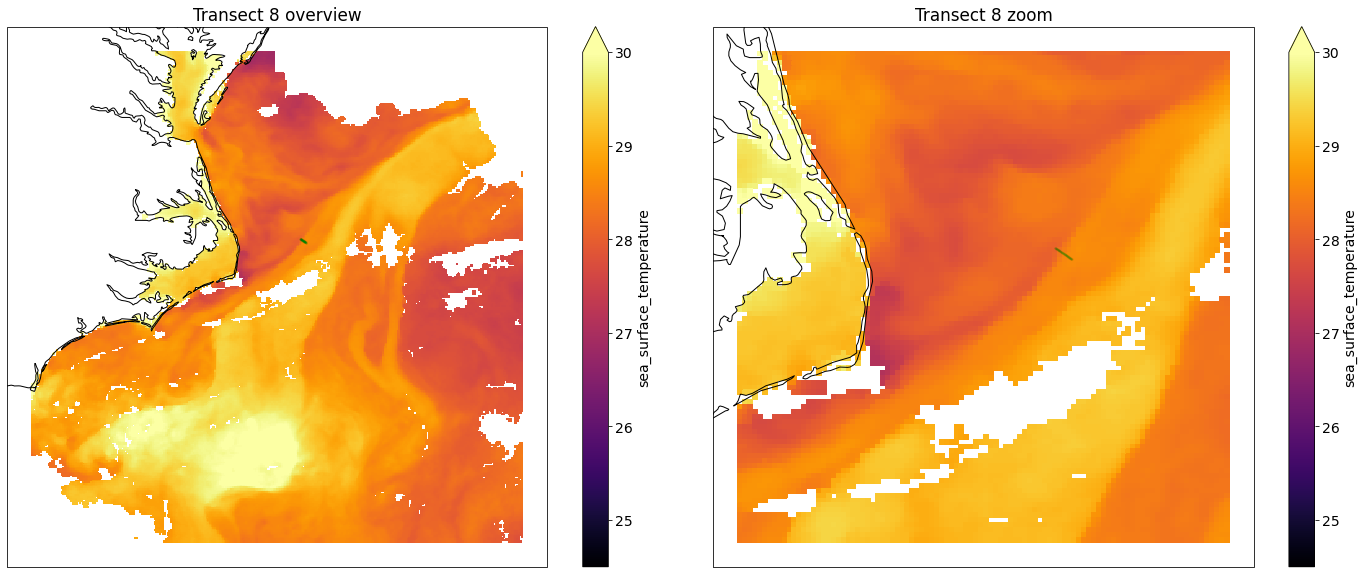

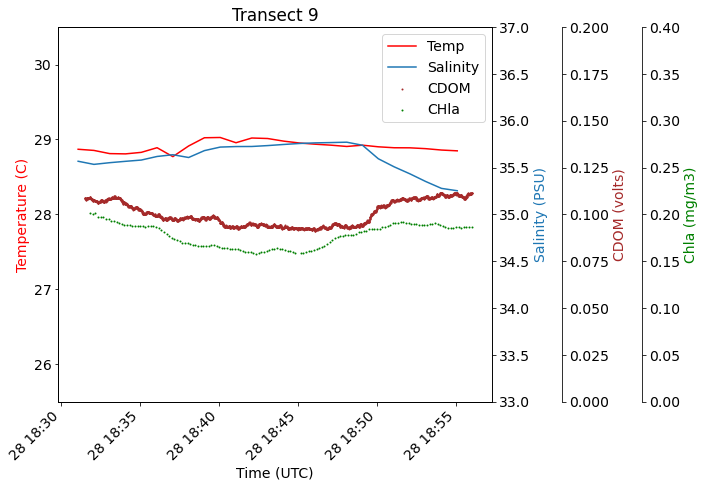

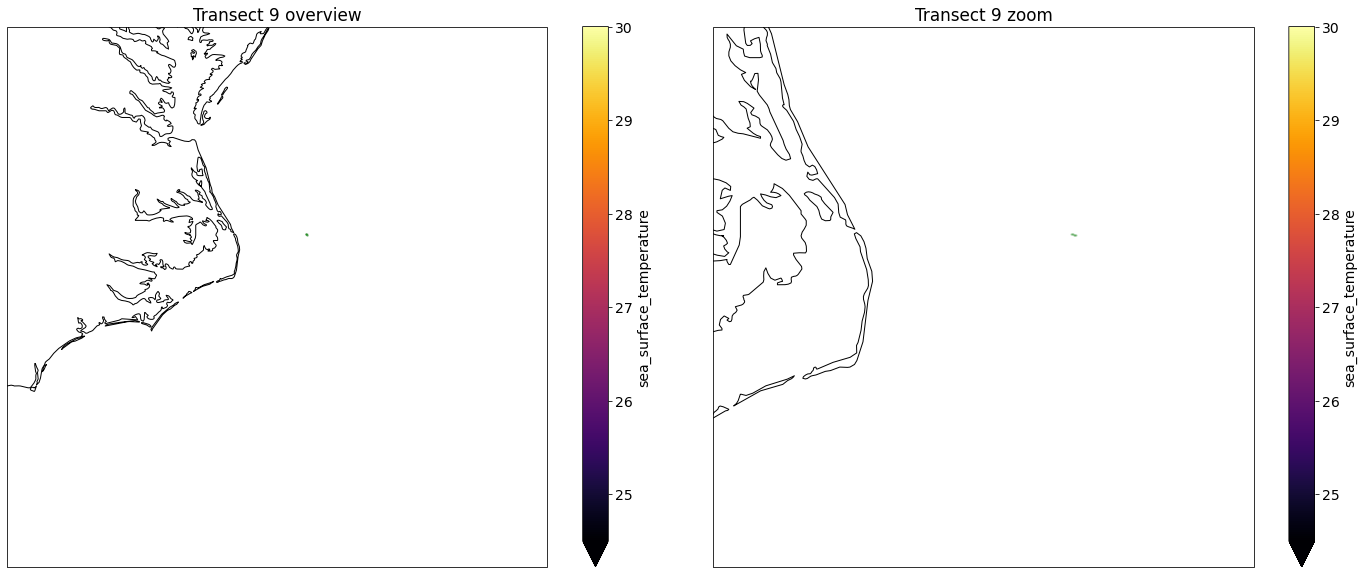

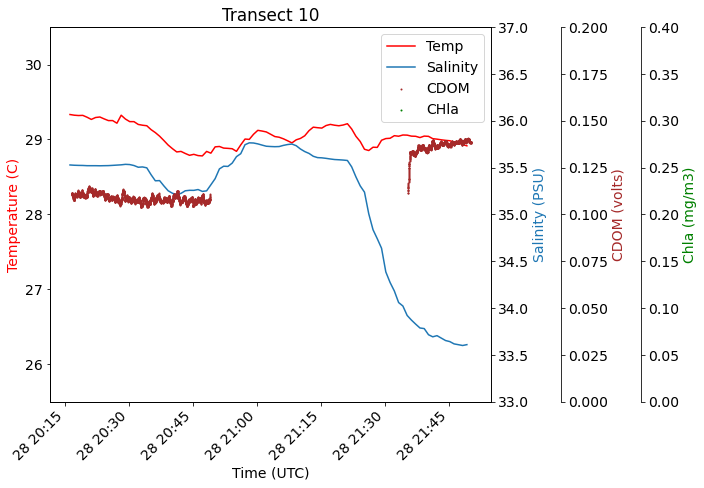

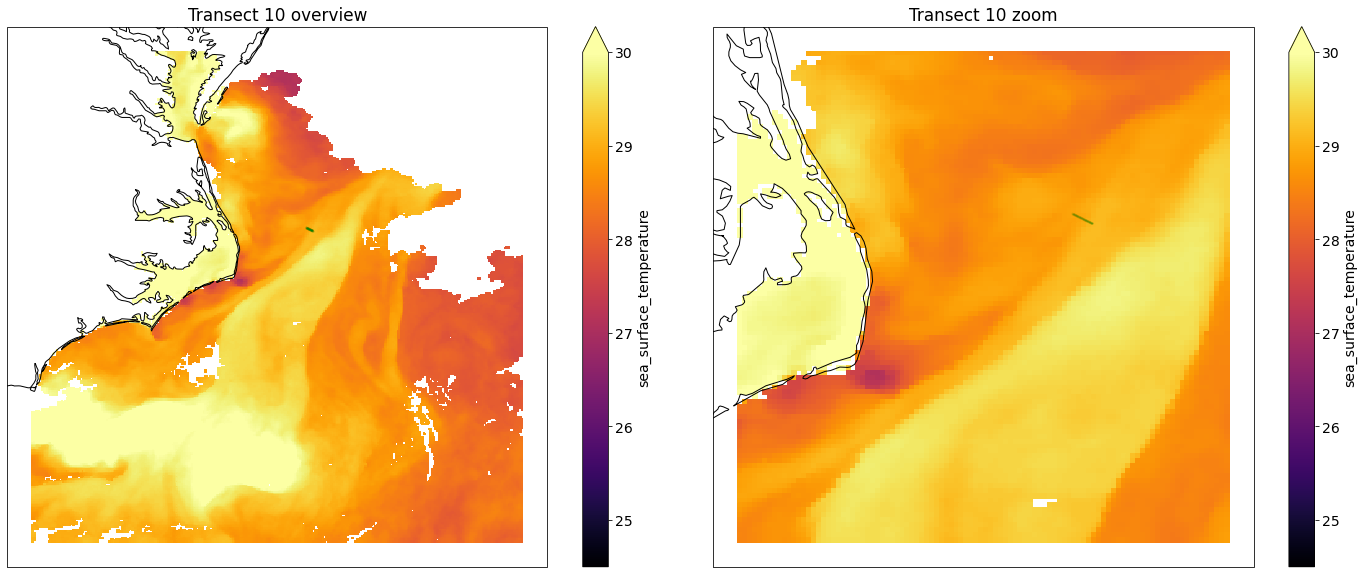

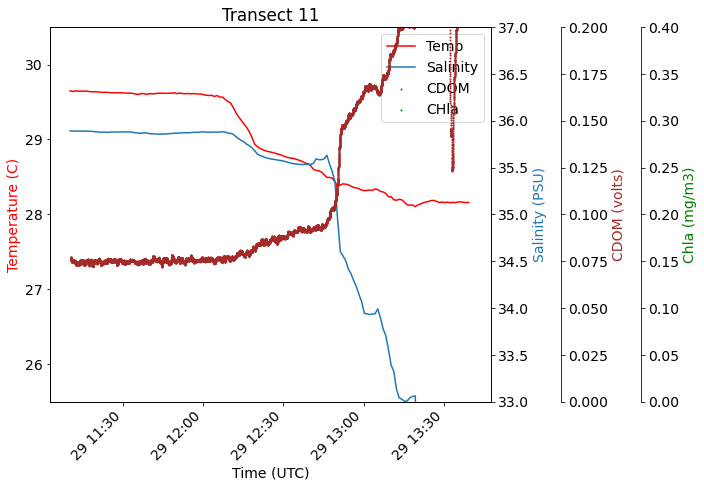

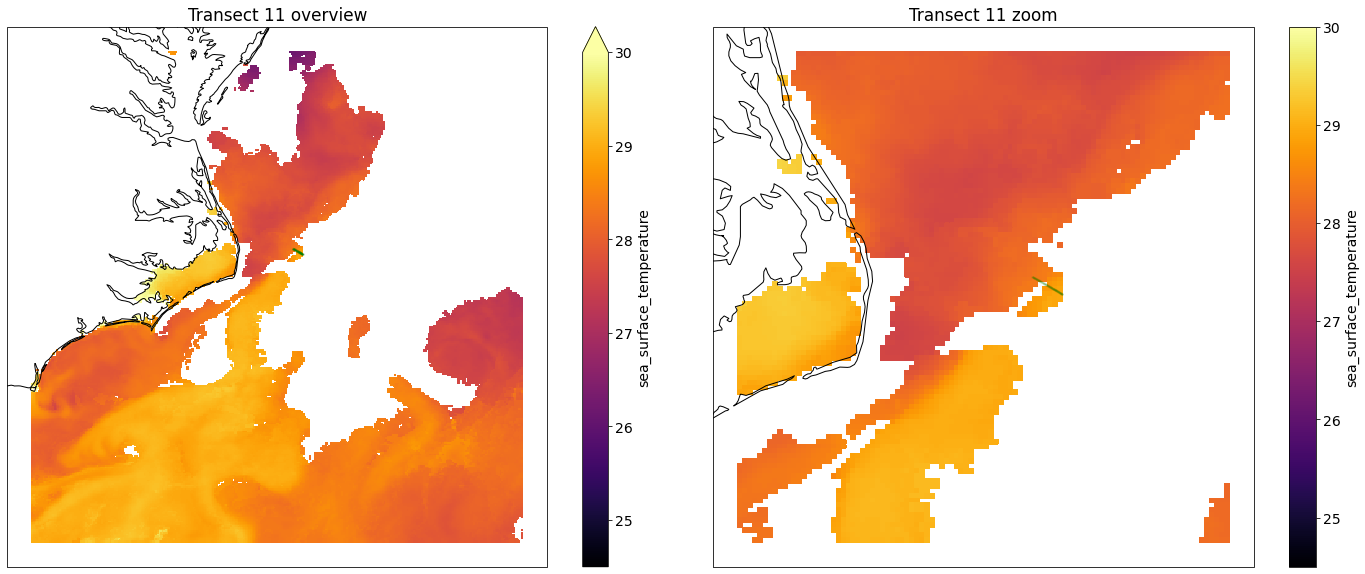

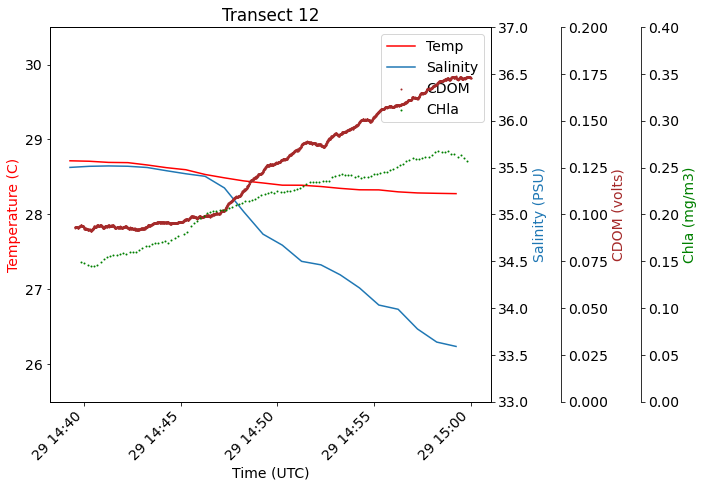

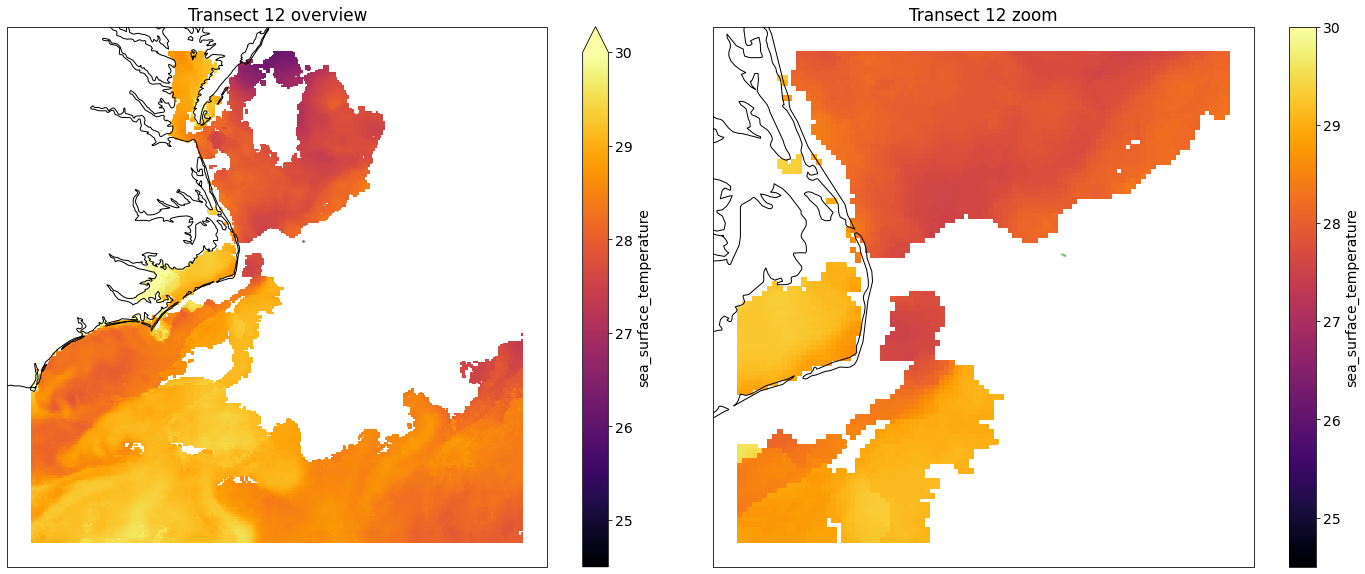

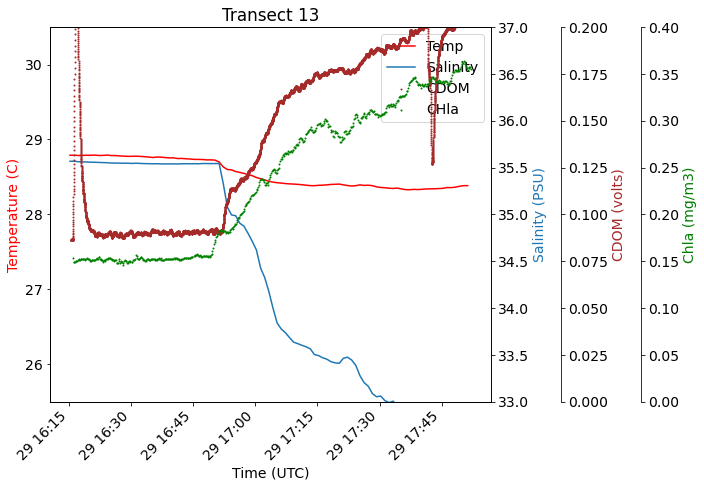

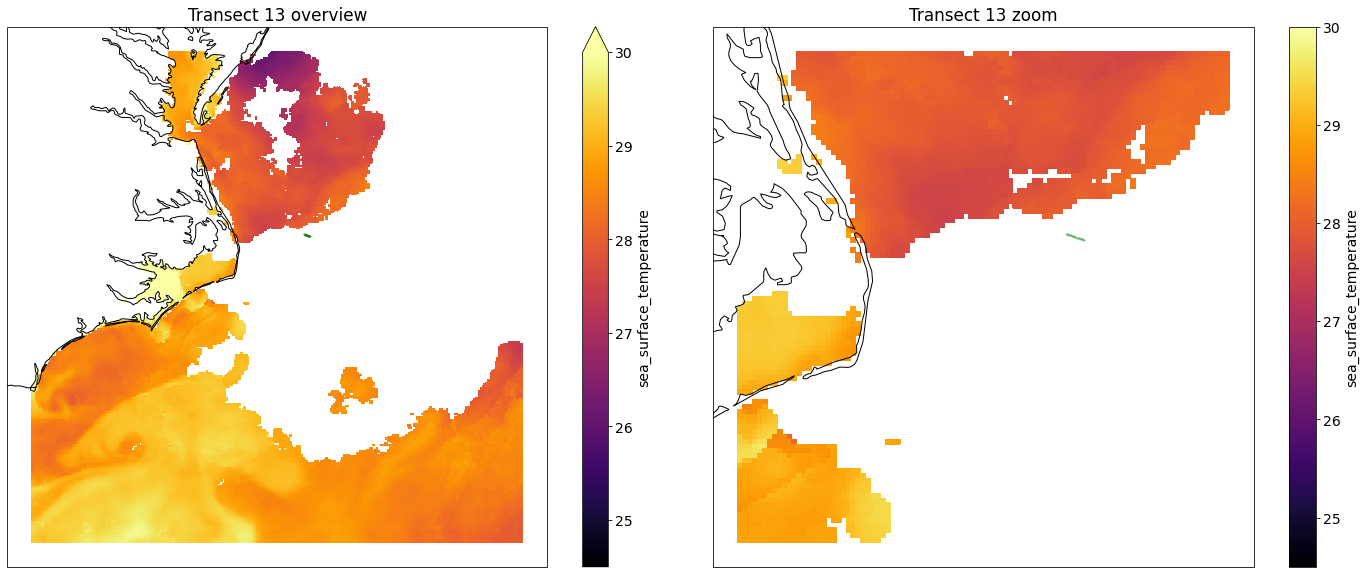

In [292]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(13):
    # time series plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    ax1 = ax.twinx()
    ax2 = ax.twinx()
    ax3 = ax.twinx()

    ax.set_ylim(25.5, 30.5)
    ax1.set_ylim(33, 37)
    ax2.set_ylim(.0, .20)
    ax3.set_ylim(.0, .40)

    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Temperature (C)")
    ax1.set_ylabel("Salinity (PSU)")
    ax2.set_ylabel("CDOM (volts)")
    ax3.set_ylabel("Chla (mg/m3)")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    
    p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
    p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
    p3  = ax2.scatter(cdom_df.loc[start_times[i]:end_times[i]].index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts'], color='brown', label='CDOM', s=1)
    
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        trios_data_x = None
        trios_data_y = None
    else:
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
    p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='CHla', s=1)
    
    ax.set_title(titles[i])


#     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
#     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
#     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

    lns = [p1, p2, p3, p4]
    ax.legend(handles=lns, loc='best')

    # right, left, top, bottom
    ax2.spines['right'].set_position(('outward', 70))
    
    ax3.spines['right'].set_position(('outward', 150))

    # no x-ticks                 
#     ax2.xaxis.set_ticks([])
    fig.autofmt_xdate(rotation=45)

    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    # Move "Velocity"-axis to the left
    # par2.spines['left'].set_position(('outward', 60))
    # par2.spines['left'].set_visible(True)
    # par2.yaxis.set_label_position('left')
    # par2.yaxis.set_ticks_position('left')

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
    ax2.yaxis.label.set_color('brown')
    ax3.yaxis.label.set_color('green')

    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'.png')
#     plt.close()
    plt.show()
    
    
    
    # SST image
    
    fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
    ax[0].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)
    
    ax[1].coastlines(resolution='10m')
    goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
    gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
    # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
    ax[0].set_title(titles[i] + ' overview')
    ax[1].set_title(titles[i] + ' zoom')
    fig.tight_layout()
#     fig.savefig('figs/'+titles[i] +'sat_overview.png')
#     plt.close()
    plt.show()    

    # fig.savefig('transect' + str(i) '_s_t.png')

In [115]:
cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean().index, cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts']

(DatetimeIndex([], dtype='datetime64[ns]', name='utc_dt', freq=None),
 Series([], Name: cdom_volts, dtype: float64))

### Radiometer Data

In [221]:
! ls data/ivan_data/trios/shearwater_trios_20210826.csv

shearwater_trios_20210826.csv	shearwater_trios_20210827.xlsx
shearwater_trios_20210826.xlsx	shearwater_trios_20210828.xlsx
shearwater_trios_20210827.csv	shearwater_trios_20210829.xlsx


In [280]:
trios_fns = [
    'data/ivan_data/trios/shearwater_trios_20210826.csv',
    'data/ivan_data/trios/shearwater_trios_20210827.csv',
    'data/ivan_data/trios/shearwater_trios_20210828.csv',
    'data/ivan_data/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

In [281]:
trios_df['TimeStamp'].head()

0    08/26/2021 12:47:30
1    08/26/2021 12:48:00
2    08/26/2021 12:48:30
3    08/26/2021 12:49:00
4    08/26/2021 12:49:30
Name: TimeStamp, dtype: object

In [282]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

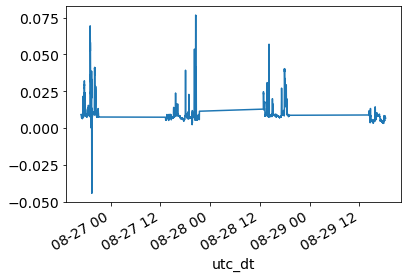

In [283]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [285]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

In [286]:
trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan

<ipython-input-286-07c79c7d9104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan


(0.0, 0.4)

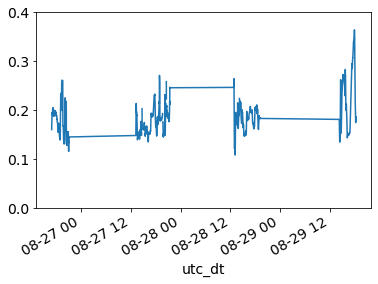

In [287]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

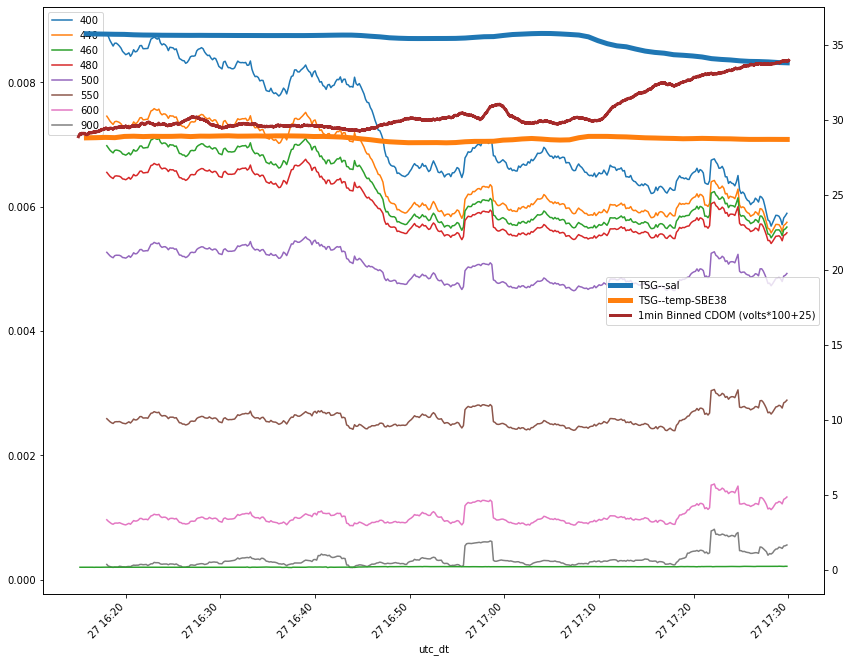

In [293]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

df_transect.plot(y='TSG--sal',ax=ax2, linewidth=5)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=5)
(cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM (volts*100+25)')
ax2.legend()

trios_df_transect['400'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['440'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['460'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['480'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['500'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['550'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['600'].rolling(window=6*3).mean().plot(ax=ax)
trios_df_transect['900'].rolling(window=6*3).mean().plot(ax=ax)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_cdom_radiometry.png')

In [299]:
plt.rcParams.update({'font.size': 16})

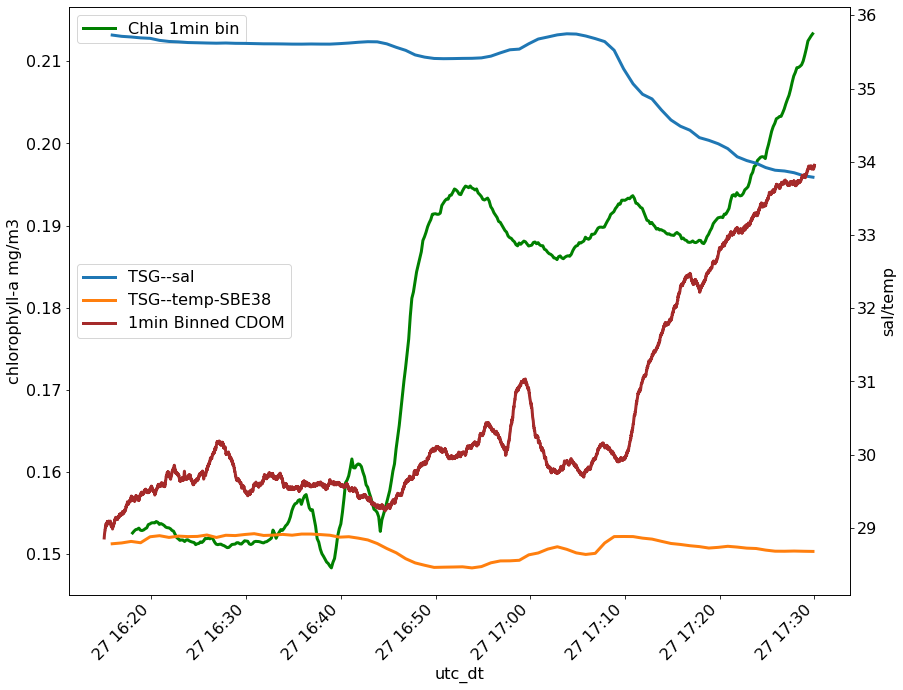

In [302]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=3)
(cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM')
ax2.legend()


trios_df_transect['chl'].rolling(window=6*3).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('sal/temp')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.savefig('sal_temp_cdom_chla.png')

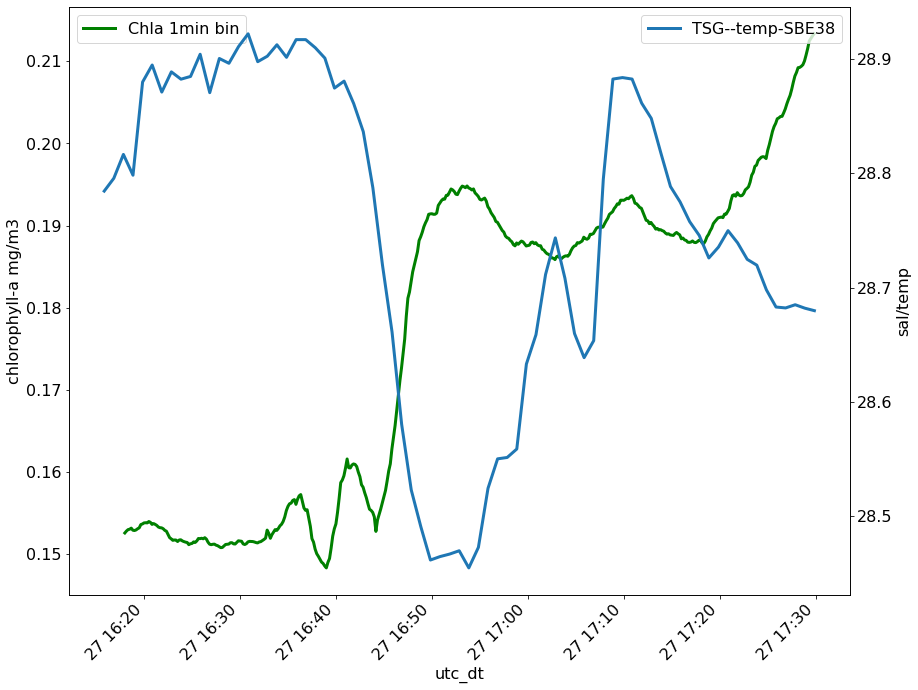

In [407]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()

# df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3)
df_transect.plot(y='TSG--temp-SBE38',ax=ax2, linewidth=3)
# (cdom_df_transect.bin_cdom*100+25).plot(color='brown', ax=ax2, linewidth=3, label='1min Binned CDOM')
ax2.legend()


trios_df_transect['chl'].rolling(window=6*3).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)

# trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00'].plot('chl', ax=ax)

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('sal/temp')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_cdom_chla.png')

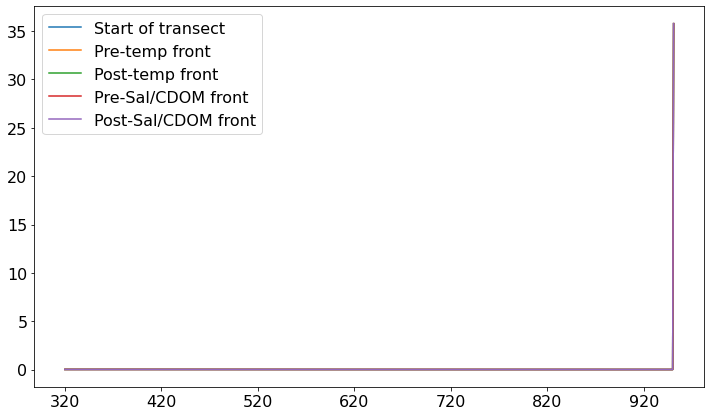

In [427]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.legend()
# plt.savefig('radiometry_spectra.png')


<AxesSubplot:>

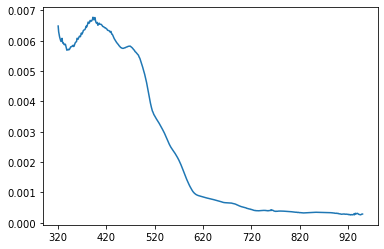

In [155]:
lats = []
lons = []
for i in range(len(trios_df)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(trios_df.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)

In [156]:
trios_df['lat'] = lats
trios_df['lon'] = lons

In [157]:
import geopandas as gpd

trios_gdf = gpd.GeoDataFrame(
    trios_df, geometry=gpd.points_from_xy(trios_df.lon, trios_df.lat))

<AxesSubplot:>

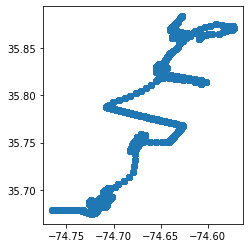

In [158]:
trios_gdf.plot()

In [166]:
trios_gdf.columns[1:-4]

Index(['320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
       ...
       '941', '942', '943', '944', '945', '946', '947', '948', '949', '950'],
      dtype='object', length=631)

In [235]:
ci1 = -0.49
ci2 = 191.6590

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    
    #print(green)
    #print(( blue + (555 - 443)/(667 - 443) * (red - blue) ))
    
    #print(CI)

    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [243]:
chlci = oc_index(trios_gdf.iloc[:, 156:161].mean(axis=1).values, trios_gdf.iloc[:, 232:240].mean(axis=1).values, trios_gdf.iloc[:, 346:351].mean(axis=1).values)

In [251]:
chlci[chlci>.5] = .5

(0.1, 0.32)

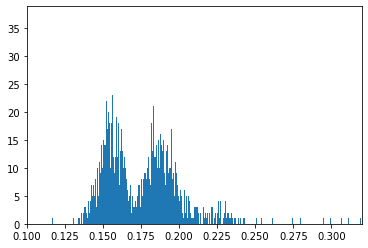

In [253]:
plt.hist(chlci, bins=2000)
plt.xlim(0.1,.32)

In [222]:
trios_gdf.iloc[:, 156:161].mean(axis=1).values

array([0.00719962, 0.00702049, 0.00608499, ..., 0.01105115, 0.00601578,
       0.00627533])

In [232]:
trios_gdf.iloc[:, 232:240].mean(axis=1).values

utc_dt
2021-08-27 13:11:50    0.004480
2021-08-27 13:12:00    0.004295
2021-08-27 13:12:10    0.003679
2021-08-27 13:12:20    0.006315
2021-08-27 13:12:30    0.004902
                         ...   
2021-08-27 21:23:00    0.003440
2021-08-27 21:23:10    0.004263
2021-08-27 21:23:20    0.008379
2021-08-27 21:23:30    0.003110
2021-08-27 21:23:40    0.003312
Length: 2919, dtype: float64

In [239]:
trios_gdf.iloc[:, 346:351].mean(axis=1).values

array([0.00259821, 0.00234837, 0.00205165, ..., 0.00616506, 0.00132067,
       0.0014643 ])

In [178]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(trios_gdf.values[:,1:-4])

In [179]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([1581,    1,    4,   18,    2,   31,    1,    7,   15,    1,    3,
          48, 1190,   16,    1]))

In [258]:
trios_gdf['chl'] = chlci

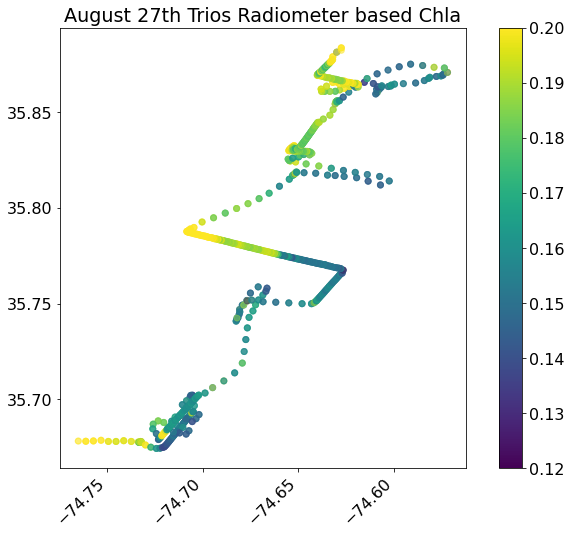

In [308]:
fig, ax = plt.subplots(figsize=(12,9))
sc = trios_gdf.plot('chl', ax=ax, vmin=.12,vmax=.20, cmap='viridis', alpha=0.3, label='CI Chla', legend=True)
# ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
# fig.colorbar(sc,ax=ax)
# fig.colorbar(sc, ax=ax)
fig.autofmt_xdate(rotation=45)
ax.set_title('August 27th Trios Radiometer based Chla')
fig.savefig('trios_radiometers_chlaci.png')

<AxesSubplot:>

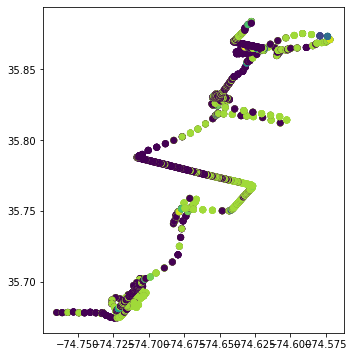

In [283]:
fig, ax = plt.subplots(figsize=(8,6))
trios_gdf.plot(c=kmeans.labels_,ax=ax)

In [310]:
trios_gdf_transect = trios_gdf.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [379]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-5]

In [380]:
x = x[12:,:]

In [381]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [383]:
principalComponents.shape

(433, 2)

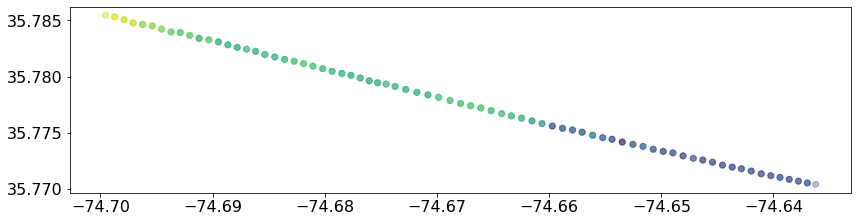

In [413]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chl,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)
fig.savefig('chla_transect.png')

In [ ]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chl,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)

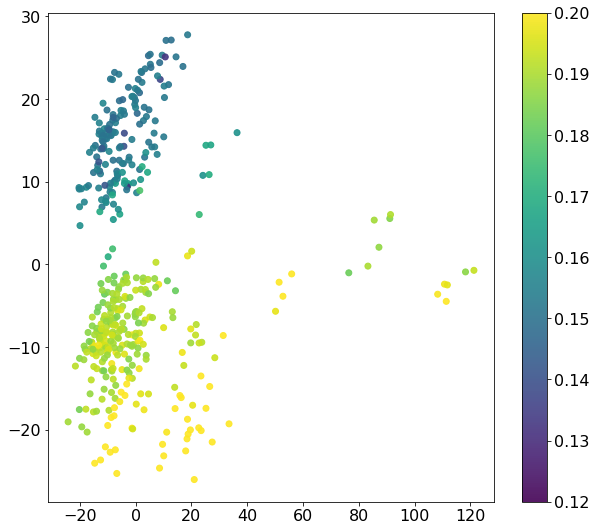

In [420]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chl'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
fig.savefig('pca_transect.png')

In [423]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 55, 210,  12,  44, 112]))

<AxesSubplot:>

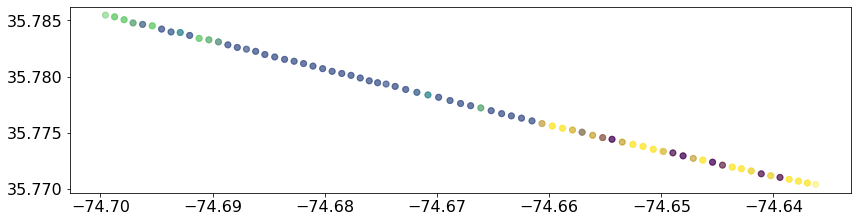

In [424]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=kmeans.labels_,ax=ax, alpha=0.2)

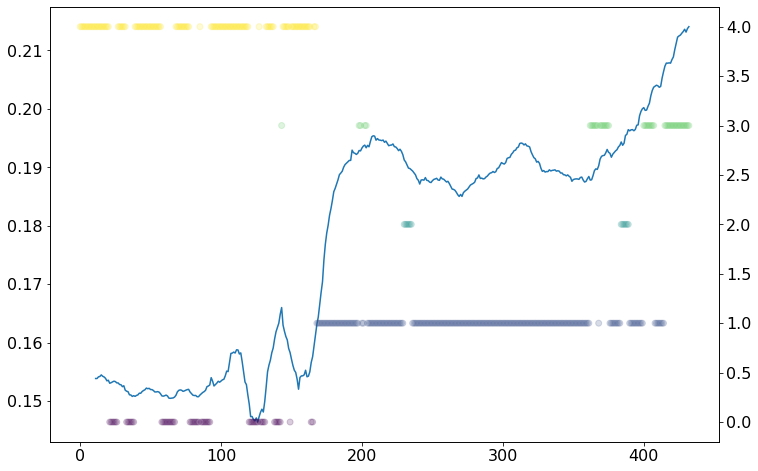

In [426]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),trios_gdf_transect.chl.iloc[12:].rolling(window=12).mean())
ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_, alpha=0.2, c=kmeans.labels_)
fig.savefig('cluster_chla.png')

In [88]:
lats = []
lons = []
for i in range(len(trios_df_transect)):
    row = df_transect.iloc[df_transect.index.get_loc(pd.to_datetime(trios_df_transect.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)

In [91]:
trios_df_transect['lat'] = lats
trios_df_transect['lon'] = lons

<ipython-input-91-aaa7d1eefef1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df_transect['lat'] = lats
<ipython-input-91-aaa7d1eefef1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df_transect['lon'] = lons


In [93]:
import geopandas as gpd

trios_gdf_transect = gpd.GeoDataFrame(
    trios_df_transect, geometry=gpd.points_from_xy(trios_df_transect.lon, trios_df_transect.lat))

<AxesSubplot:>

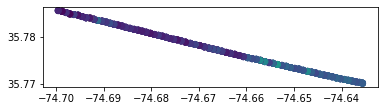

In [100]:
trios_gdf.plot('455')